# 6.2 ラプラス近似(Laplace approximation)
1. 勾配法によって、事後分布の極大値を1つ求め、近似用の正規分布の平均とする。
1. 求めた極大値において、､2階微分が一致するように近似用の正規分布の分散を求める。

In [2]:
# パッケージの読み込み
using Distributions, PyPlot, ForwardDiff, LinearAlgebra

In [3]:
# n次元単位行列
eye(n) = Diagonal{Float64}(I, n)

# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [4]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

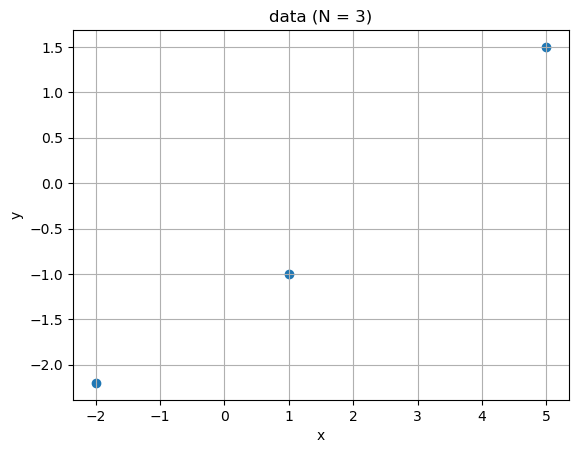

In [5]:
# 入力データセット
X_obs = [-2, 1, 5]

# 出力データセット
Y_obs = [-2.2, -1.0, 1.5]

# 散布図で可視化
fig, ax = subplots()
ax.scatter(X_obs, Y_obs)
set_options(ax, "x", "y", "data (N = $(length(X_obs)))")

## 6.2.1 線形回帰（単一パラメータ）

In [6]:
# 切片は0で固定
w₂ = 0

# yに付加されるノイズの標準偏差
σ = 1.0

# 事前分布の平均値と標準偏差
μ₁ = 0.0
σ₁ = 10.0

10.0

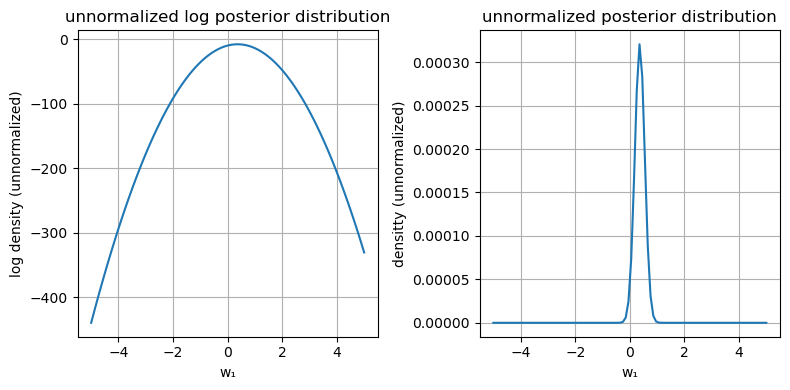

In [15]:
# 非正規化対数事後分布
ulp(w₁) = sum(logpdf.(Normal.(w₁*X_obs .+ w₂, σ), Y_obs)) + logpdf(Normal(μ₁, σ₁), w₁)

# 分布を表示する範囲
w₁s = range(-5, 5, length=100)

fig, axes = subplots(1, 2, figsize=(8, 4))

# # 非正規化対数事前分布の可視化
axes[1].plot(w₁s, ulp.(w₁s))
set_options(axes[1], "w₁", "log density (unnormalized)", "unnormalized log posterior distribution")

#　非正規化事後分布の可視化
axes[2].plot(w₁s, exp.(ulp.(w₁s)))
set_options(axes[2], "w₁", "densitty (unnormalized)", "unnormalized posterior distribution")

tight_layout()

In [16]:
# １変数関数の最適化
function gradient_method_1dim(f, x_init, η, maxiter)
    # 最適化過程のパラメータを格納する配列
    x_seq = Array{typeof(x_init), 1}(undef, maxiter)
    
    # 勾配
    fʼ(x) = ForwardDiff.derivative(f, x)
    
    # 初期値
    x_seq[1] = x_init
    
    # メインの最適化ループ
    for i in 2:maxiter
        x_seq[i] = x_seq[i-1] + η*fʼ(x_seq[i-1])
    end
    
    x_seq
end

gradient_method_1dim (generic function with 1 method)

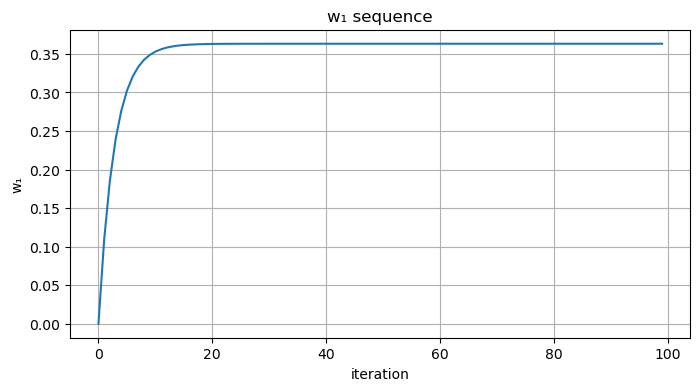

In [17]:
# 最適化パラメータ
w₁_init = 0.0
maxiter = 100
η = 0.01

# 最適化の実施
w₁_seq = gradient_method_1dim(ulp, w₁_init, η, maxiter)

# 勾配法の過程を可視化
fig, ax = subplots(figsize=(8,4))
ax.plot(w₁_seq)
set_options(ax, "iteration", "w₁", "w₁ sequence")

In [56]:
# 最適化パラメータ
w₁_init = 0.0
maxiter = 100
η = 0.01

# 対数同時分布　paramsは変数として使えない？
log_joint(w₁, X, Y, w₂, σ, μ₁, σ₁) = sum(logpdf.(Normal.(w₁*X .+ w₂, σ), Y)) + logpdf(Normal(μ₁, σ₁), w₁)
paras = (X_obs, Y_obs, w₂, σ, μ₁, σ₁)

# 最適化のラッパー関数の定義
function inference_wrapper_gd_1dim(log_joint, paras, w₁_init, η, maxiter)
    ulp(w₁) = log_joint(w₁, paras...)
    w₁_seq = gradient_method_1dim(ulp, w₁_init, η, maxiter)
    w₁_seq
end

# 最適化の実施
w₁_seq = inference_wrapper_gd_1dim(log_joint, paras, w₁_init, η, maxiter)
w₁_seq'

1×100 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.109  0.185289  0.238684  0.276055  …  0.363212  0.363212  0.363212

In [58]:
# 最適化パラメータ
w₁_init = 0.0
maxiter = 1_000_000
η = 0.01

# グローバル変数を参照する場合
@time gradient_method_1dim(ulp, w₁_init, η, maxiter)

# ラッパーを使う場合
@time inference_wrapper_gd_1dim(log_joint, paras, w₁_init, η, maxiter)
print()

  1.053506 seconds (21.00 M allocations: 740.043 MiB, 10.04% gc time)
  0.136737 seconds (9.00 M allocations: 328.056 MiB, 9.42% gc time)


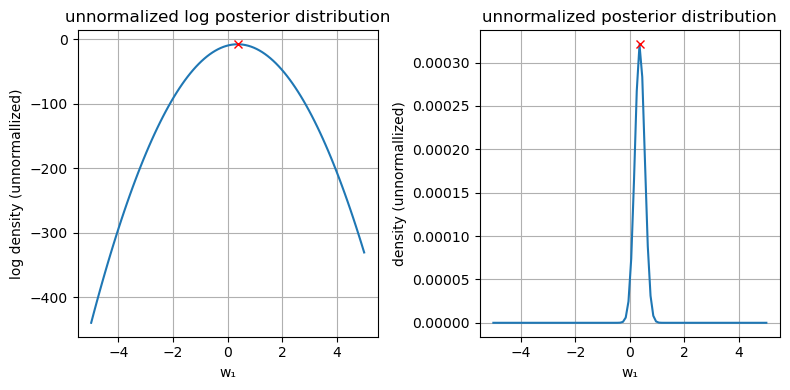

In [59]:
# 近似分布用の平均を求める
μ_approx = w₁_seq[end]

w₁s = range(-5, 5, length=100)

fig, axes = subplots(1, 2, figsize=(8, 4))

# 非正規化対数事後分布と最適値
axes[1].plot(w₁s, ulp.(w₁s))
axes[1].plot(μ_approx, ulp(μ_approx), "rx", label="optimal")
set_options(axes[1], "w₁", "log density (unnormallized)", "unnormalized log posterior distribution")

# 非正規化事後分布と最適値
axes[2].plot(w₁s, exp.(ulp.(w₁s)))
axes[2].plot(μ_approx, exp.(ulp(μ_approx)), "rx", label="optimal")
set_options(axes[2], "w₁", "density (unnormallized)", "unnormalized posterior distribution")

tight_layout()

In [60]:
# 2階微分から分散を求める
grad(x) = ForwardDiff.derivative(ulp, x)
hessian(x) = ForwardDiff.derivative(grad, x)
σ_approx = sqrt(inv(-hessian(μ_approx)))

0.1825437644092281

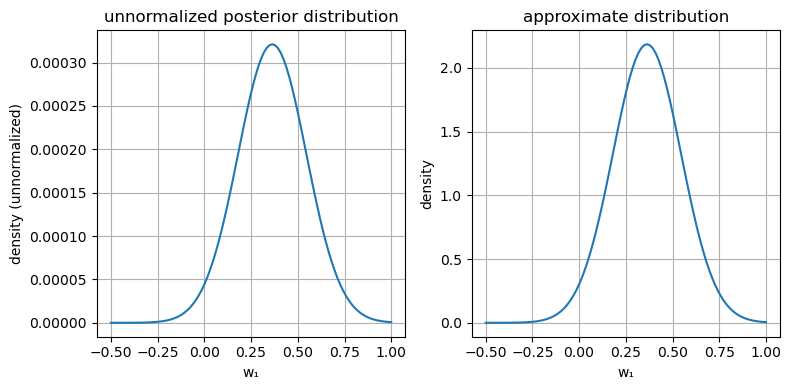

In [61]:
# 可視化する範囲
w₁s = range(-0.5, 1.0, length=100)

# 非正規化事後分布の可視化
fig, axes = subplots(1, 2, figsize=(8, 4))
axes[1].plot(w₁s, exp.(ulp.(w₁s)))
set_options(axes[1], "w₁", "density (unnormalized)", "unnormalized posterior distribution")

# 得られた近似分布の可視化
axes[2].plot(w₁s, pdf.(Normal.(μ_approx, σ_approx), w₁s))
set_options(axes[2], "w₁", "density", "approximate distribution")

tight_layout()